In [1]:
import pandas as pd
import numpy as np
import requests
import urllib

from sqlalchemy import create_engine

# Custom upload with connection string
from engine_info import server_info

import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
# Creating a connection to MS SQL SERVER
params = urllib.parse.quote_plus(server_info)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
connection = engine.connect()

In [19]:
# Upload sales data
sales = pd.read_sql_table(
    table_name='Durban_Fresh_produce_market',
    con=connection,
    parse_dates=['Date']
)

## Data preparation

In [20]:
# Check the first five rows
sales.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
0,APPLE GOLDEN DELICIOUS,9.00,2S,JE090,CAPE,50.00,100.00,51.39,9250,180,1620,1397,2020-02-26
1,APPLE GOLDEN DELICIOUS,9.00,2S,JE090,ORANGE FREE STATE,0.00,0.00,0.00,0,0,0,80,2020-02-26
2,APPLE GOLDEN DELICIOUS,9.00,2S,JE090,NATAL,10.00,10.00,10.00,30,3,27,6,2020-02-26
3,APPLE GOLDEN DELICIOUS,9.00,2U,JE090,CAPE,50.00,50.00,50.00,9000,180,1620,0,2020-02-26
4,APPLE GOLDEN DELICIOUS,18.30,2X,M4183,CAPE,0.00,0.00,0.00,0,0,0,1,2020-02-26


In [21]:
# View datatype of each column
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151571 entries, 0 to 151570
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Commodities     151571 non-null  object        
 1   Weight_Kg       151571 non-null  object        
 2   Size_Grade      151571 non-null  object        
 3   Container       151571 non-null  object        
 4   Province        151571 non-null  object        
 5   Low_Price       151571 non-null  object        
 6   High_Price      151571 non-null  object        
 7   Average_Price   151571 non-null  object        
 8   Sales_Total     151571 non-null  object        
 9   Total_Qty_Sold  151571 non-null  object        
 10  Total_Kg_Sold   151571 non-null  object        
 11  Stock_On_Hand   151571 non-null  object        
 12  Date            151571 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(12)
memory usage: 15.0+ MB


In [22]:
# Convert some of the columns to their appropriate data type
float_columns = ['Weight_Kg', 'Low_Price', 'High_Price', 'Average_Price', 
                 'Sales_Total', 'Total_Kg_Sold', 'Total_Qty_Sold', 'Stock_On_Hand']


# Convert the columns to numeric
for col in float_columns:
    # sales[col] = sales[col].astype(float)
    sales[col] = pd.to_numeric(sales[col])

In [23]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151571 entries, 0 to 151570
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Commodities     151571 non-null  object        
 1   Weight_Kg       151571 non-null  float64       
 2   Size_Grade      151571 non-null  object        
 3   Container       151571 non-null  object        
 4   Province        151571 non-null  object        
 5   Low_Price       151571 non-null  float64       
 6   High_Price      151571 non-null  float64       
 7   Average_Price   151571 non-null  float64       
 8   Sales_Total     151570 non-null  float64       
 9   Total_Qty_Sold  151570 non-null  float64       
 10  Total_Kg_Sold   151571 non-null  float64       
 11  Stock_On_Hand   151570 non-null  float64       
 12  Date            151571 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 15.0+ MB


In [24]:
sales.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
0,APPLE GOLDEN DELICIOUS,9.0,2S,JE090,CAPE,50.0,100.0,51.39,9250.0,180.0,1620.0,1397.0,2020-02-26
1,APPLE GOLDEN DELICIOUS,9.0,2S,JE090,ORANGE FREE STATE,0.0,0.0,0.00,0.0,0.0,0.0,80.0,2020-02-26
2,APPLE GOLDEN DELICIOUS,9.0,2S,JE090,NATAL,10.0,10.0,10.00,30.0,3.0,27.0,6.0,2020-02-26
3,APPLE GOLDEN DELICIOUS,9.0,2U,JE090,CAPE,50.0,50.0,50.00,9000.0,180.0,1620.0,0.0,2020-02-26
4,APPLE GOLDEN DELICIOUS,18.3,2X,M4183,CAPE,0.0,0.0,0.00,0.0,0.0,0.0,1.0,2020-02-26


In [27]:
# Check for the number of days in the database
print(f"{sales['Date'].nunique()} days recorded in the database")

147 days recorded in the database


In [28]:
# Remove days whereby total sales equal 0 because it registers average_price as zero.
filtered_sales = sales[sales['Sales_Total'] != 0]

In [29]:
print(f"{filtered_sales['Date'].nunique()} days recorded in the database")

147 days recorded in the database


Therefore no days were lost due to filtering by 'Sales_Total'

In [31]:
filtered_sales.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
0,APPLE GOLDEN DELICIOUS,9.0,2S,JE090,CAPE,50.0,100.0,51.39,9250.0,180.0,1620.0,1397.0,2020-02-26
2,APPLE GOLDEN DELICIOUS,9.0,2S,JE090,NATAL,10.0,10.0,10.00,30.0,3.0,27.0,6.0,2020-02-26
3,APPLE GOLDEN DELICIOUS,9.0,2U,JE090,CAPE,50.0,50.0,50.00,9000.0,180.0,1620.0,0.0,2020-02-26
7,APPLE GRANNY SMITH,12.0,1S,EC120,CAPE,60.0,60.0,60.00,6000.0,100.0,1200.0,164.0,2020-02-26
8,APPLE GRANNY SMITH,12.0,1S,EC120,CAPE,60.0,96.0,62.30,13020.0,209.0,2508.0,0.0,2020-02-26


In [53]:
# Check PINEAPPLE commodity to observe daily sales
sales[(sales['Commodities'] == 'PINEAPPLE QUEEN VICTORIA') & (sales['Container'] == 'LM080') & (sales['Province'] == 'NATAL')].head(20)

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
791,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,60.0,120.0,113.82,18780.0,165.0,1320.0,149.0,2020-04-07
792,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,50.0,100.0,92.00,65410.0,711.0,5688.0,430.0,2020-04-07
793,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,40.0,90.0,83.25,44290.0,532.0,4256.0,44.0,2020-04-07
794,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,15.0,70.0,57.78,9765.0,169.0,1352.0,46.0,2020-04-07
795,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,15.0,120.0,120.00,840.0,7.0,56.0,5.0,2020-04-07
1892,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,225.0,225.0,225.00,80775.0,359.0,2872.0,6.0,2020-05-19
1893,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,200.0,200.0,200.00,224800.0,1124.0,8992.0,100.0,2020-05-19
1894,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,200.0,200.0,200.00,88600.0,443.0,3544.0,2.0,2020-05-19
1895,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,180.0,180.0,180.00,13140.0,73.0,584.0,0.0,2020-05-19
1896,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,160.0,160.0,160.00,2400.0,15.0,120.0,5.0,2020-05-19


Based on the above table, it can be seen that multiple sales are taking place on the same day, which means that the data has to be consolidated to one day.

In [80]:
# Consolidation of repeated sales in a single day of the same product to one day
df = filtered_sales.groupby(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities', 'Date']
    )[['Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand']].agg(
        {
            'Low_Price':min,
            'High_Price':max,
            'Sales_Total':sum,
            'Total_Qty_Sold':sum,
            'Total_Kg_Sold':sum,
            'Stock_On_Hand':sum
        }
)

In [81]:
df

Low_Price  \
Province          Container Size_Grade Weight_Kg Commodities             Date                    
                  A8075                7.5       HABANERO YELLOW         2020-07-01      350.0   
                                                                         2020-07-08      350.0   
                                                                         2020-07-09      350.0   
                                                                         2020-07-14      350.0   
                                                                         2020-07-20      300.0   
...                                                                                        ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10        8.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23        5.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23        5.0   
                                                                         2020-06-19        5.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19       20.0   

                                                                                     High_Price  \
Province          Container Size_Grade Weight_Kg Commodities             Date                     
                  A8075                7.5       HABANERO YELLOW         2020-07-01       350.0   
                                                                         2020-07-08       350.0   
                                                                         2020-07-09       350.0   
                                                                         2020-07-14       350.0   
                                                                         2020-07-20       320.0   
...                                                                                         ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10        10.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23        10.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23         5.0   
                                                                         2020-06-19         5.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19        20.0   

                                                                                     Sales_Total  \
Province          Container Size_Grade Weight_Kg Commodities             Date                      
                  A8075                7.5       HABANERO YELLOW         2020-07-01        700.0   
                                                                         2020-07-08       1400.0   
                                                                         2020-07-09       1400.0   
                                                                         2020-07-14       1050.0   
                                                                         2020-07-20        620.0   
...                                                                                          ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10       1080.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23       5470.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23       1440.0   
                                                                         2020-06-19        835.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19         20.0   

                                                                                     Total_Qty_Sold  \
Province          Container Size_Grade Weight_Kg Commodities             Date                         
               

In [82]:
df.reset_index(inplace=True)

In [83]:
df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,,A8075,,7.5,HABANERO YELLOW,2020-07-01,350.0,350.0,700.0,2.0,15.0,6.0
1,,A8075,,7.5,HABANERO YELLOW,2020-07-08,350.0,350.0,1400.0,4.0,30.0,12.0
2,,A8075,,7.5,HABANERO YELLOW,2020-07-09,350.0,350.0,1400.0,4.0,30.0,12.0
3,,A8075,,7.5,HABANERO YELLOW,2020-07-14,350.0,350.0,1050.0,3.0,22.5,2.0
4,,A8075,,7.5,HABANERO YELLOW,2020-07-20,300.0,320.0,620.0,2.0,15.0,0.0


In [84]:
df['avg_per_kg'] = round(df['Sales_Total'] / df['Total_Kg_Sold'], 2)

In [85]:
df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_per_kg
0,,A8075,,7.5,HABANERO YELLOW,2020-07-01,350.0,350.0,700.0,2.0,15.0,6.0,46.67
1,,A8075,,7.5,HABANERO YELLOW,2020-07-08,350.0,350.0,1400.0,4.0,30.0,12.0,46.67
2,,A8075,,7.5,HABANERO YELLOW,2020-07-09,350.0,350.0,1400.0,4.0,30.0,12.0,46.67
3,,A8075,,7.5,HABANERO YELLOW,2020-07-14,350.0,350.0,1050.0,3.0,22.5,2.0,46.67
4,,A8075,,7.5,HABANERO YELLOW,2020-07-20,300.0,320.0,620.0,2.0,15.0,0.0,41.33


In [98]:
# Check which product is sold on a daily basis
day_count = sales['Date'].nunique()
df.groupby(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities'])['Commodities'].value_counts().apply(lambda x: x / day_count).sort_values(ascending=False)

Province  Container  Size_Grade  Weight_Kg  Commodities             Commodities           
CAPE      EC120      1S          12.0       APPLE GOLDEN DELICIOUS  APPLE GOLDEN DELICIOUS    1.000000
NATAL     ST170                  17.0       CHILLIES GREEN          CHILLIES GREEN            0.986395
          NE005                  0.5        CURRY LEAVES            CURRY LEAVES              0.986395
          BI100                  10.0       BRINJALS                BRINJALS                  0.986395
          AT200                  20.0       CABBAGE                 CABBAGE                   0.986395
                                                                                                ...   
          BF070      1L          7.0        CUCUMBERS ENGLISH       CUCUMBERS ENGLISH         0.006803
                                            LEMON                   LEMON                     0.006803
                     1M          7.0        CUCUMBERS ENGLISH       CUCUMBERS ENGLISH

Based on the results above, **APPLE GOLDEN DELICIOUS** has been sold for every day that is recorded in the database. For this notebook, this product will be used as a template for developing a forecasting model.

In [182]:
price = df[
    (df['Commodities'] == 'APPLE GOLDEN DELICIOUS') & 
    (df['Weight_Kg'] == 12.0) &
    (df['Size_Grade'] == '1S') &
    (df['Container'] == 'EC120') &
    (df['Province'] == 'CAPE')
]

In [183]:
price.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_per_kg
4350,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-11,50.0,140.0,3840.0,33.0,396.0,1117.0,9.70
4351,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-12,100.0,144.0,129546.0,1151.0,13812.0,2070.0,9.38
4352,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-14,100.0,140.0,7734.0,63.0,756.0,2865.0,10.23
4353,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-23,40.0,200.0,99673.0,1519.0,18228.0,6017.0,5.47
4354,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-30,50.0,140.0,69874.0,892.0,10704.0,1272.0,6.53


In [184]:
price = price[['Date', 'avg_per_kg']]

In [185]:
price.set_index('Date', inplace=True)

In [186]:
price.head()

,avg_per_kg
Date,
2019-12-11,9.70
2019-12-12,9.38
2019-12-14,10.23
2019-12-23,5.47
2019-12-30,6.53


In [187]:
price.sort_index(inplace=True)

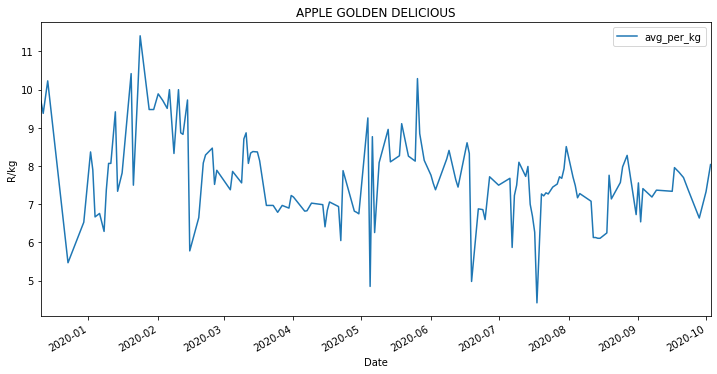

In [189]:
ax = price.plot(figsize=(12,6), title="APPLE GOLDEN DELICIOUS")
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='R/kg');

In [195]:
copy_price = price.copy()

In [199]:
# Simple Moving Average for different periods
copy_price['5-day-SMA'] = copy_price['avg_per_kg'].rolling(window=5).mean() # Idealy a week
copy_price['5-day-Std'] = copy_price['avg_per_kg'].rolling(window=5).std() # 

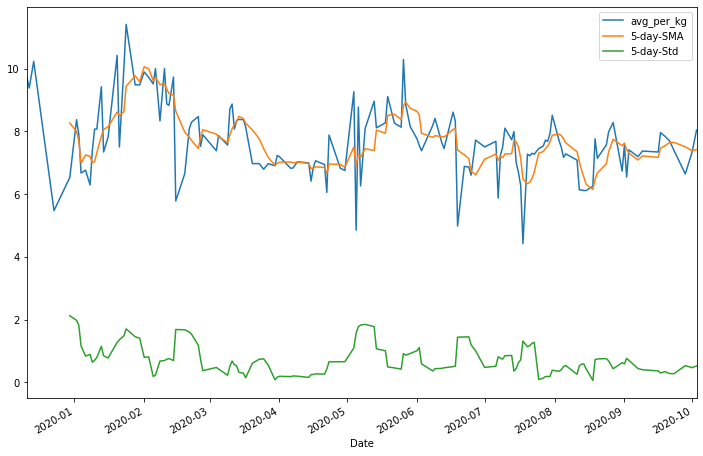

In [200]:
ax = copy_price[['avg_per_kg', '5-day-SMA', '5-day-Std']].plot()
ax.autoscale(axis='x', tight=True);

In [122]:
price.index

DatetimeIndex(['2019-12-11', '2019-12-12', '2019-12-14', '2019-12-23',
               '2019-12-30', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-06', '2020-01-08',
               ...
               '2020-09-07', '2020-09-09', '2020-09-16', '2020-09-17',
               '2020-09-19', '2020-09-21', '2020-09-23', '2020-09-28',
               '2020-10-01', '2020-10-03'],
              dtype='datetime64[ns]', name='Date', length=147, freq=None)

The freq of the index is currently set to None, this will need to be changed to daily, since the frequency of the data is daily. Furthermore, since there is no data available for weekends, the freq has to be set to Business day (Mon-Fri), with a backfill method to account for those days when it is a holiday and no data updated. 

In [123]:
price = price.asfreq('B', method='backfill')

In [124]:
price.index

DatetimeIndex(['2019-12-11', '2019-12-12', '2019-12-13', '2019-12-16',
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24',
               ...
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-25', '2020-09-28', '2020-09-29', '2020-09-30',
               '2020-10-01', '2020-10-02'],
              dtype='datetime64[ns]', name='Date', length=213, freq='B')

## Introduction

Due to competition, retailers aim to increase profits and reduce costs, increasing the profit margin for perishable food products. This means that avoiding costs due to lost sales, and because of the short-shelf life of their products, ensuring that there is no build up of inventory. Effecient forecasting system can result in reduced inventory, be flexible to changes and increase profits. 

Time series is a series of data points indexed by time typically in an ordered equally spaced manner. Time serves as the only feature in this format of data, and behavior of the data is analyzed through time. Time series forecasting uses past observations of the same variable to develop a model describing the underlying relationship. The model is then used to extrapolate time series into the future. This approach is useful when there are no other explanatory variables influencing the generation of the underlying data. 

### Trend

The Hodrick-Prescott filter is used to get the trend of the data. This approach separates the time-series into a trend component and a cyclical component.

In [125]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [126]:
# Tuple unpacking
price_cycle, price_trend = hpfilter(price)

In [127]:
price['trend'] = price_trend

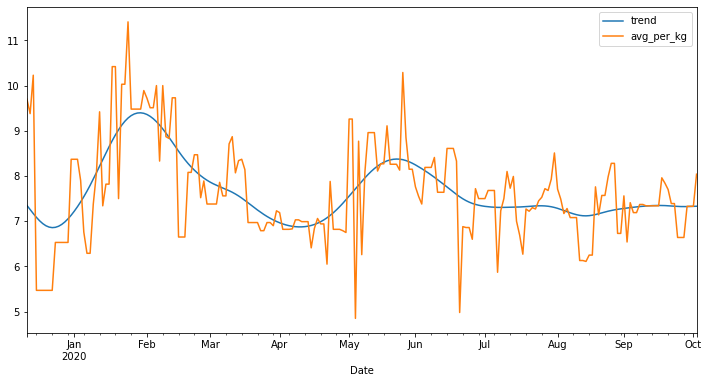

In [130]:
ax = price[['trend','avg_per_kg']].plot(figsize=(12,6))
ax.autoscale(axis='x',tight=True);

In [132]:
del price['trend']

### Seasonal Decomposition

Time series decomposition involves the deconstruction of the time series data into the level, trend, seasonal and noise component. The model is assumed to be additive, i.e. value of our variable is given by the summation of it's deconstructed components.
<p style="text-align: center; font-weight: bold;">
y(t) = level + trend + seasonality + noise
</p>

In [136]:
rcParams['figure.figsize'] = 12,8

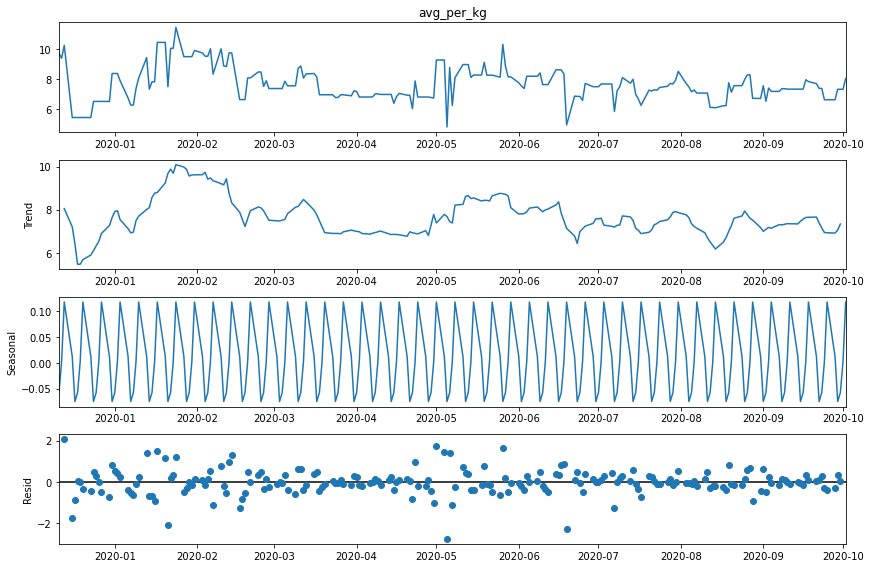

In [137]:
result = seasonal_decompose(price['avg_per_kg'], model='additive')  # model='mul' also works
result.plot();

## Holt - Winters method

Holt - Winters method is a generalized exponential smooothing method that incorporates **trend** and **seasonal** variation in the model. The model makes use of exponential weighting of the coefficients of past observations in order to give more weight to the most recent observations. 

In [138]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [151]:
train_data = price.iloc[:-30]
test_data = price.iloc[-30:]

In [152]:
model = ExponentialSmoothing(train_data['avg_per_kg'], trend='add',seasonal='add',seasonal_periods=7) 
fitted_model = model.fit()

In [153]:
test_predictions = fitted_model.forecast(30).rename('Forecast')

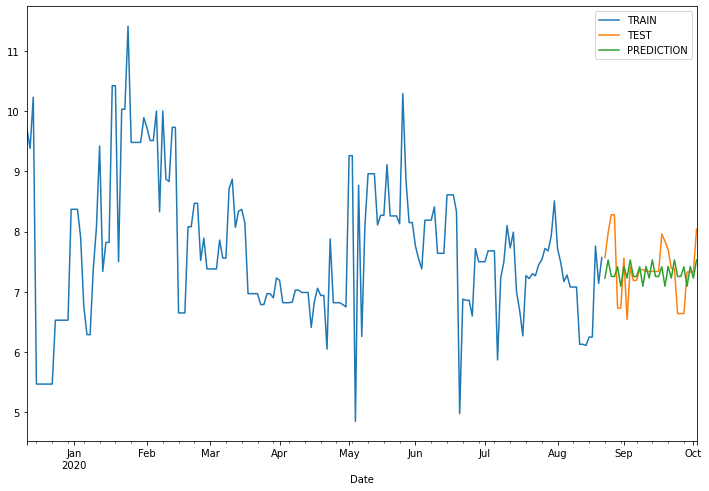

In [154]:
train_data['avg_per_kg'].plot(legend=True, label='TRAIN')
test_data['avg_per_kg'].plot(legend=True, label='TEST')
test_predictions.plot(legend=True, label='PREDICTION');

In [225]:
test_predictions

2020-08-24    7.229024
2020-08-25    7.529269
2020-08-26    7.257621
2020-08-27    7.254415
2020-08-28    7.415814
2020-08-31    7.092611
2020-09-01    7.422135
2020-09-02    7.229024
2020-09-03    7.529269
2020-09-04    7.257621
2020-09-07    7.254415
2020-09-08    7.415814
2020-09-09    7.092611
2020-09-10    7.422135
2020-09-11    7.229024
2020-09-14    7.529269
2020-09-15    7.257621
2020-09-16    7.254415
2020-09-17    7.415814
2020-09-18    7.092611
2020-09-21    7.422135
2020-09-22    7.229024
2020-09-23    7.529269
2020-09-24    7.257621
2020-09-25    7.254415
2020-09-28    7.415814
2020-09-29    7.092611
2020-09-30    7.422135
2020-10-01    7.229024
2020-10-02    7.529269
Freq: B, Name: Forecast, dtype: float64

In [155]:
from sklearn.metrics import mean_squared_error

In [156]:
hw_pred = np.sqrt(mean_squared_error(test_data, test_predictions))

In [157]:
hw_pred

0.46032820502827554

## Autoregressive (AR) model

The Holt-Winters method forecasts the variable of interest using a linear combination of predictors. These predictors are the set of level, trend and seasonal predictors. 

The autoregression model uses a linear combination of past values of the variable. This is a regression equation whereby the variable of interest is regressed against a set of it's lagged values of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

In [158]:
# Import AR model
from statsmodels.tsa.ar_model import AR

In [166]:
model = AR(train_data['avg_per_kg'])

### AR(1) model

In [167]:
ar1 = model.fit(maxlag=1)

In [168]:
# This is the general format for obtaining predictions
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions1 = ar1.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

### AR(2) model

In [169]:
model = AR(train_data['avg_per_kg'])
ar2 = model.fit(maxlag=2)
predictions2 = ar2.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

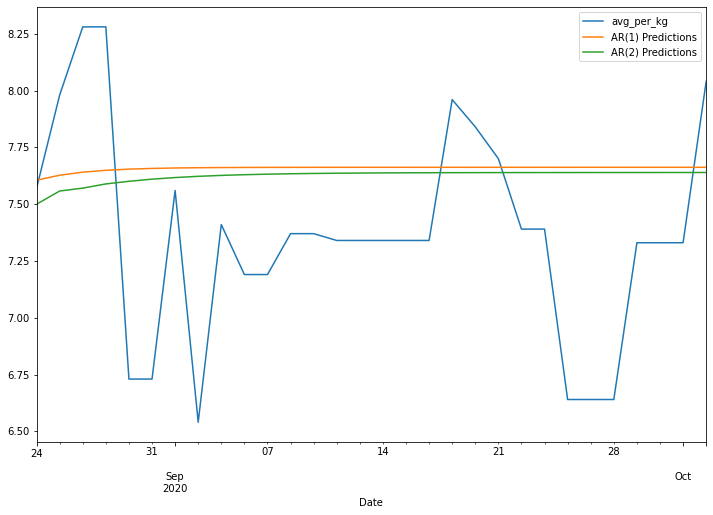

In [170]:
test_data['avg_per_kg'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True);

### AR(5) model

In [171]:
model = AR(train_data['avg_per_kg'])
ar5 = model.fit(maxlag=5)
predictions5 = ar5.predict(start=start, end=end, dynamic=False).rename('AR(5) Predictions')

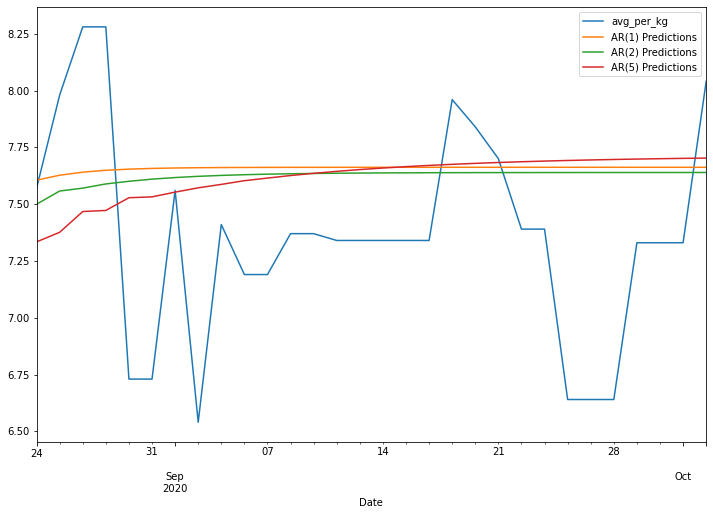

In [172]:
test_data['avg_per_kg'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions5.plot(legend=True);

In [173]:
# Identify the best AR() model to use for forecasting
model = AR(train_data['avg_per_kg'])
arfit = model.fit()

In [174]:
arfit.params

const             1.596795
L1.avg_per_kg     0.418476
L2.avg_per_kg     0.154755
L3.avg_per_kg     0.004047
L4.avg_per_kg     0.042746
L5.avg_per_kg     0.124350
L6.avg_per_kg     0.047907
L7.avg_per_kg     0.060190
L8.avg_per_kg    -0.100266
L9.avg_per_kg     0.114718
L10.avg_per_kg   -0.139039
L11.avg_per_kg    0.008470
L12.avg_per_kg    0.026933
L13.avg_per_kg    0.003974
L14.avg_per_kg    0.027926
dtype: float64

### AR(14) model

In [175]:
model = AR(train_data['avg_per_kg'])
ar7 = model.fit(maxlag=14)
predictions7 = ar7.predict(start=start, end=end, dynamic=False).rename('AR(14) Predictions')

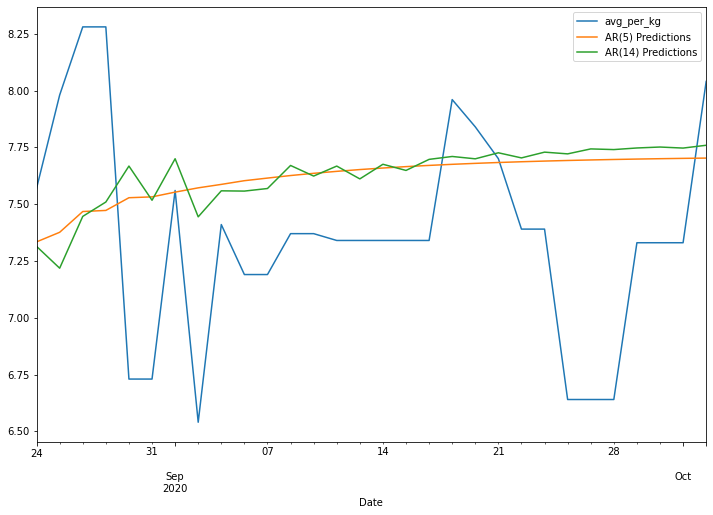

In [176]:
test_data['avg_per_kg'].plot(legend=True)
predictions5.plot(legend=True)
predictions7.plot(legend=True);

## Stationarity tests

## Autoregressive Moving Average (ARMA) model

ARMA model is a combination of two models, the AR model utilizing past values of the time series data, and the Moving Average (MA) model, which uses past values of the forecast errors. 

### $$ y_{t} = c + \sum^p_{i=1} \phi_{i} y_{t-i} + \sum^q_{j=1} \theta_{j} \varepsilon_{t-j} + \varepsilon_{t} $$

As seen earlier, this models can be also be used separately, or in this section, combined. The fitting process returns estimated coefficients, $\phi_{i}$ and $\theta_{i}$, but prior to this process, the order ($p,q$) of the model needs to be determined.

## Autoregressive Integrated Moing Average (ARIMA) model

In [180]:
from pmdarima import auto_arima

In [201]:
from statsmodels.tools.eval_measures import rmse

In [218]:
model = auto_arima(train_data['avg_per_kg'],error_action='ignore', suppress_warnings=True, start_p=0, start_q=0,
                          max_p=6, max_q=3)

In [219]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  183
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -239.863
Date:                Sun, 11 Oct 2020   AIC                            487.726
Time:                        13:30:45   BIC                            500.564
Sample:                             0   HQIC                           492.930
                                - 183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3075      0.499      2.618      0.009       0.328       2.286
ar.L1          0.8308      0.062     13.399      0.000       0.709       0.952
ma.L1         -0.3570      0.082     -4.359      0.000      -0.518      -0.196
sigma2         0.8027      0.058     13.764      0.000       0.688       0.917
===================================================================================
Ljung-Box (Q):                       30.79   Jarque-Bera (JB):               139.02
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [204]:
model.fit(train_data['avg_per_kg'])

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [205]:
predictions = model.predict(n_periods=len(test_data))

In [210]:
predictions = pd.Series(predictions, index=test_data.index)

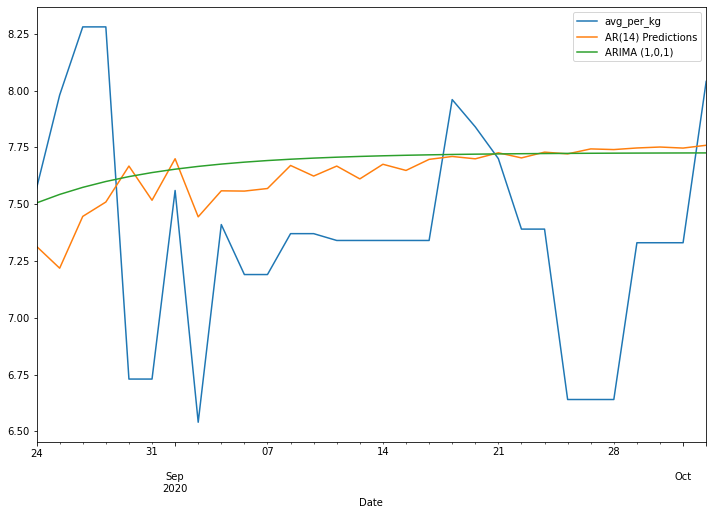

In [212]:
test_data['avg_per_kg'].plot(legend=True)
predictions7.plot(legend=True)
predictions.plot(legend=True, label="ARIMA (1,0,1)");

In [223]:
for forecast, model in zip(
        [predictions1, predictions2, predictions5, predictions7, predictions, test_predictions],
        ['AR(1)', 'AR(2)', 'AR(5)', 'AR(14)', 'ARIMA(1,0,1)', 'HW']):
    print(f'{model}: {rmse(test_data["avg_per_kg"], forecast)}')

AR(1): 0.5472504076697607
AR(2): 0.5354252663622752
AR(5): 0.555141222387028
AR(14): 0.5696909746033652
ARIMA(1,0,1): 0.5749101985405419
HW: 0.46032820502827554


In [221]:
model

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [222]:
model.order

(1, 0, 1)